This script parses .log-files obtained in the functional sessions, converts them to BIDS-compatible _events.tsv-files, and does some simple statistical analyses of the behavioral data

In [1]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import json
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import re
#%matplotlib inline

### .log-file to \_events.tsv conversion

For participant 10 session SE, the Presentation software was restarted after run 1. As a consequence, the behavioral data is split in two separate log-files. Here, we concatenate these to a single .log-file, and the parse that. It's a bit of a detour but ensures we use a single parsing function for all data.


In [3]:
fn_run1 = './data/raw/behavior/to_combine/S10s2-stop_fmri.log'
fn_run2 = './data/raw/behavior/to_combine/S10s2-stop_fmri1.log'

log1 = pd.read_csv(fn_run1, sep='\t', skiprows=2)
log2 = pd.read_csv(fn_run2, sep='\t', skiprows=2)
final_time1 = log1.iloc[-1]['Time']
final_trial1 = log1.iloc[-1]['Trial']

# remove quit from Log1
log1 = log1.iloc[:-1]

log2['Time'] = log2['Time'] + final_time1 + 4 # add 4 seconds ="pause"
log2['Trial'] = log2['Trial'] + final_trial1
combined = pd.concat([log1, log2])

# parse_log_file skips the first two rows when reading data. Therefore, make sure there's no data on the first two rows
dfNans = pd.DataFrame({'a':[np.nan] * 2})
dfNans.to_csv('./data/raw/behavior/to_combine/S10s2-stop_combined.log', index=False, header=None)
combined.to_csv('./data/raw/behavior/to_combine/S10s2-stop_combined.log', sep='\t', mode='a')  # append

Define parsing function

In [4]:
# fn = './data/raw/behavior/S1s1-stop_fmri.log'

def parse_log_file(fn, session_type, out_dir='./data/deriv/fmriprep', log=None, save=True, return_long=True, return_wide=True):
    # out_dir should be the root folder of the bids structure
    # 
    
    if log is None:
        log = pd.read_csv(fn, sep='\t', skiprows=2)

    # Get runs based on largest difference between times
    log['Time'] = log['Time'] - log['Time'].iloc[0]
    log['delta_t'] = log['Time'].diff().fillna(1e5) # fillna so that the first trial gets a delta_5 very high
    log['run'] = (log['delta_t'] > 40010.0) & (log['Event Type'] == 'Pulse') # TR is 3s, that's 30000 in Presentation-lingo; so anything above 4 is definitely a break
    log['run'] = log['run'].cumsum()

    # Find start time of each run
    log['delta_run'] = log['run'].diff().fillna(1.)

    # find start time of each run
    log['run_start_time'] = np.nan
    log.loc[log['delta_run'] == 1., 'run_start_time'] = log.loc[log['delta_run'] == 1., 'Time']
    log['run_start_time'].fillna(method='ffill', inplace=True)

    # make all times relative to start time of the run
    log['Time'] = log['Time'] - log['run_start_time']

    # convert all times & durations to seconds
    log['Time'] = log['Time'] / 10000
    log['Duration'] = log['Duration'] / 10000

    # remove pulses, remove fixation cross
    log = log.loc[log['Code'] != '255']
    fix_cross_idx = log['Code'].apply(lambda x: 'fixation' in str(x))
    log = log.loc[~fix_cross_idx]

    def get_jitter(x):
        # gets trial type + jitter code
        if isinstance(x, str):
            return x.split('_')[-1]
        return None

    def get_trial_type(x):
        if isinstance(x, str):
            if 'STOP_0' in x:
                return 'go'
            elif 'STOP_1' in x or 'STOP_2' in x:
                return 'stop'

        return np.nan

    log['trial_type'] = log['Code'].apply(lambda x: get_trial_type(x))

    # Get responses
    responses = log.loc[(log['Event Type'] == 'Response')].copy()
    responses['response_direction'] = np.nan
    responses['response_direction'] = responses['Code'].map({'1': 'response_left', '2': 'response_right'})
    log = pd.merge(log, responses[['Trial', 'response_direction', 'Time']], on='Trial', suffixes=('', '_response'), how='left')

    # code event types
    log['event_type'] = np.nan
    log.loc[pd.isnull(log['trial_type']), 'event_type'] = log.loc[pd.isnull(log['trial_type']), 'response_direction']
    log.loc[log['trial_type'] == 'go', 'event_type'] = 'go_trial'
    log.loc[(log['trial_type'] == 'stop') & pd.isnull(log['Time_response']), 'event_type'] = 'successful_stop'
    log.loc[(log['trial_type'] == 'stop') & pd.notnull(log['Time_response']), 'event_type'] = 'failed_stop'
    log['jitter'] = log['Code'].apply(lambda x: get_jitter(x))  # Jitter?
    log['event_type_jitter'] = log['event_type'].map(str) + '_' + log['jitter'].map(str)

    # make some prettier stuff
    log['Trial'] = log['Trial']/2

    # per-subject adjustments here
    import re
    regx = re.compile('.*S(?P<sub>[0-9]+)s(?P<sesn>[0-9]+)-stop_*')
    grd = regx.match(fn).groupdict()
    sub = str(grd['sub']).zfill(2)
    ses = session_type
    if sub == '07' and ses == 'se':
        # for this participant, the screen was accidentally only turned on after the first trial.
        log = log.loc[log['Trial'] > 1]
    
    log_small = log[['Time', 'Duration', 'event_type', 'Time_response', 'event_type_jitter', 'run', 'response_direction']].copy()
    log_small.rename(columns={'Time': 'onset', 
                              'Duration': 'duration', 
                              'Time_response': 'response_time',
                              'event_type': 'trial_type',
                              'event_type_incl_jitter': 'event_type_jitter',
                              'response_direction': 'response_direction'}, inplace=True)

    if save:
        # set-up file name for saving
        subject_formatted = 'sub-' + sub
        session = 'ses-' + session_type # + str(log.iloc[0,0][3].zfill(1))
        save_dir = os.path.join(out_dir, subject_formatted, session, 'func')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        for run in [1,2,3]:
            log_this_run = log_small.loc[log.run==run]
            fn_this_run = '_'.join([subject_formatted, session,  'task-stop', 'run-' + str(run), 'events.tsv'])
            log_this_run.to_csv(os.path.join(save_dir, fn_this_run), sep='\t', index=False)
            
    if return_long:
        return(log_small)
        
    if return_wide:
        # some additional stuff useful for behavioral data analysis
        log = log.loc[log['Event Type'] == 'Picture'].copy()
        log['rt'] = log['Time_response'] - log['Time']
        log['staircase'] = pd.to_numeric(log['Code'].apply(lambda x: x.split('_')[3]), errors='coerce')
        log['ssd'] = pd.to_numeric(log['Code'].apply(lambda x: x.split('_')[4]), errors='coerce')
        log['stimulus_direction'] = log['Code'].apply(lambda x: x.split('_')[5])
        log['stimulus_direction'] = log['stimulus_direction'].map({'-1': 'left', '1': 'right'})
        log.loc[pd.notnull(log.response_direction), 'response_direction'] = log.loc[pd.notnull(log.response_direction), 'response_direction'].apply(lambda x: x.split('_')[1])        
        log['correct_response'] = log['stimulus_direction'] == log['response_direction']
        log['jitter'] = log['Code'].apply(lambda x: x.split('_')[6])
        return(log)

In [5]:
def get_behavioral_descriptives(fn, plot_save_fn, session_type, **kwargs):
    import re
    regex = re.compile('.*S(?P<sub>\d+)s(?P<ses>\d+)*')
    all_behav = parse_log_file(fn, session_type, **kwargs)
    
    # some plots
    import seaborn as sns
    cols = ['red', 'green', 'blue']
    
#    f = plt.Figure()
    f, ax = plt.subplots(2, 1)
    for run in [1,2,3]:
        sns.distplot(all_behav.loc[(all_behav.run==run) & (all_behav.correct_response==1) & (all_behav.trial_type=='go'), 'rt'],
                          color=cols[run-1], ax=ax[0])
        ax[0].set_title('RTs per block (correct go responses only)')
        ax[0].set_xlabel('RT (s)')
        ax[0].set_ylabel('Density')

    for run in [1,2,3]:
        for staircase in [1, 2]:
            line_style = '-' if staircase == '1' else ':'
            ax[1].plot(all_behav.loc[(all_behav.run==run) & (all_behav.trial_type=='stop') & (all_behav.staircase==staircase), 'ssd'],
                    linestyle=line_style, color=cols[run-1])
    ax[1].set_title('Staircases per block')
    ax[1].set_xlabel('Trial N')
    ax[1].set_ylabel('SSD (ms)')
    subsesdict = regex.match(fn).groupdict()    
    f.suptitle('Sub %s, session %s (%s)' %(subsesdict['sub'], subsesdict['ses'], session_type))
    f.tight_layout()
    f.savefig(plot_save_fn, bbox_type='tight')
    
    def get_correct(x):
        return(np.nanmean(x.loc[(x.trial_type!='stop'), 'correct_response']))

    def get_prop_success_stop(x):
        return(np.mean(pd.isnull(x.loc[(x.trial_type=='stop'), 'rt'])))
    
    def get_n_stop(x):
        return(np.sum(x.trial_type=='stop'))

    print('N stopping trials:')
    print(all_behav.groupby('run').apply(lambda x: get_n_stop(x)))
    
    print('Percentage correct responses of go-trials:')
    print(all_behav.groupby('run').apply(lambda x: get_correct(x)))

    print('\nPercentage successful stops of stop-trails:')
    print(all_behav.groupby('run').apply(lambda x: get_prop_success_stop(x)))

35
./data/raw/behavior/S1s1-stop_fmri.log


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


N stopping trials:
run
1    30
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.988235
2    0.988235
3    1.000000
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.466667
2    0.551724
3    0.448276
dtype: float64
./data/raw/behavior/S1s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.988235
2    0.976471
3    1.000000
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.551724
2    0.517241
3    0.379310
dtype: float64
./data/raw/behavior/S2s1-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.988235
2    1.000000
3    1.000000
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.517241
2    0.517241
3    0.551724
dtype: float64
./data/raw/behavior/S2s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage co

/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.976744
2    0.823529
3    1.000000
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.448276
2    0.448276
3    0.413793
dtype: float64
./data/raw/behavior/S11s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    1.0
2    1.0
3    1.0
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.586207
2    0.517241
3    0.482759
dtype: float64
./data/raw/behavior/S12s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.682353
2    0.376471
3    0.941860
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.862069
2    0.724138
3    0.275862
dtype: float64
./data/raw/behavior/S13s1-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct respon

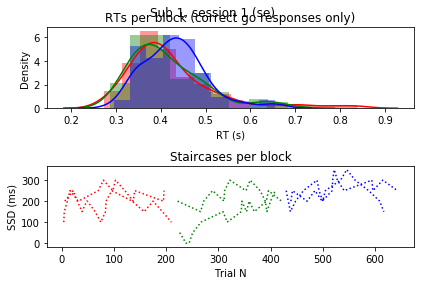

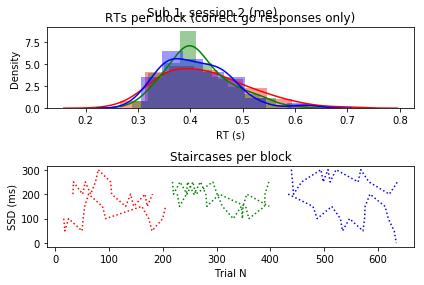

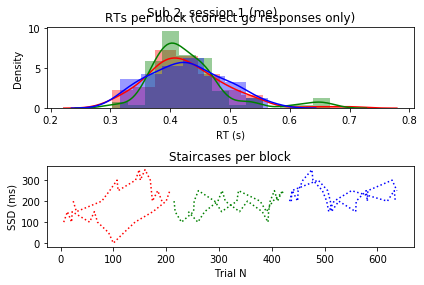

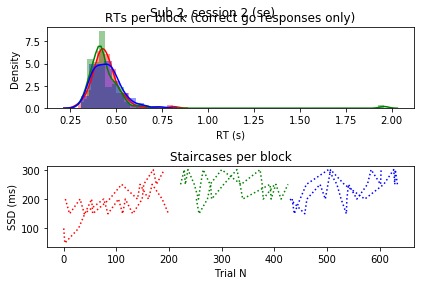

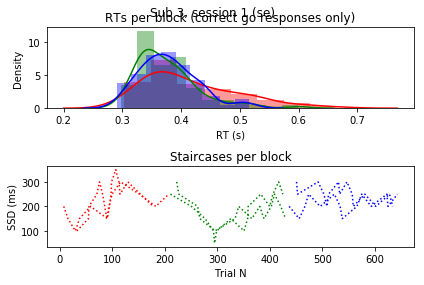

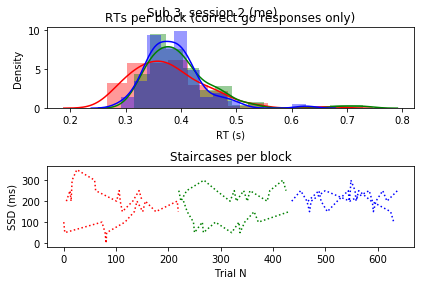

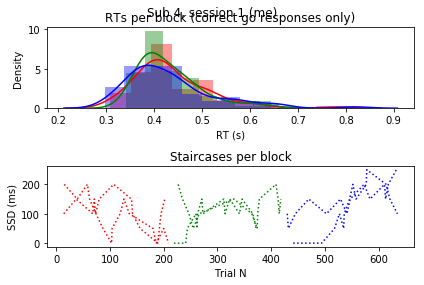

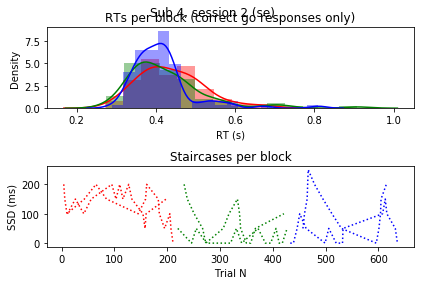

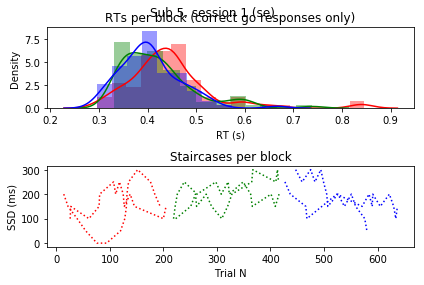

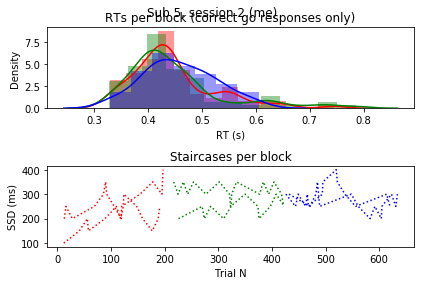

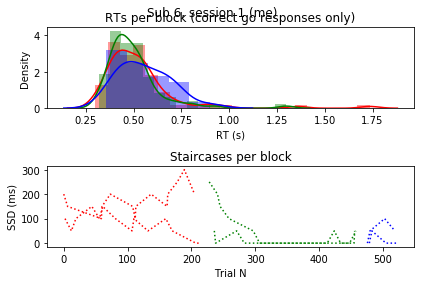

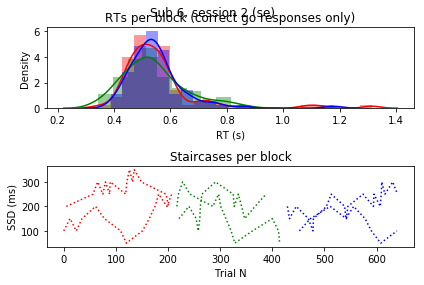

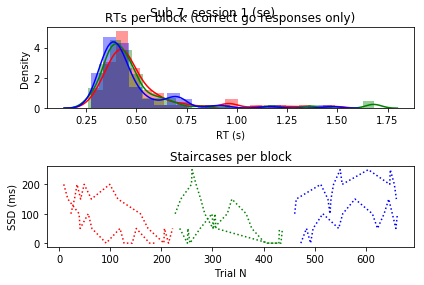

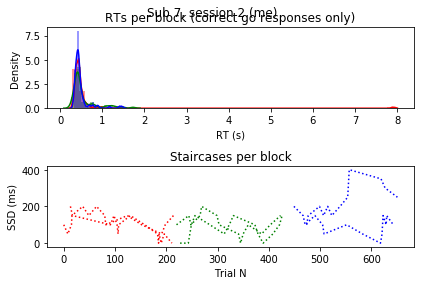

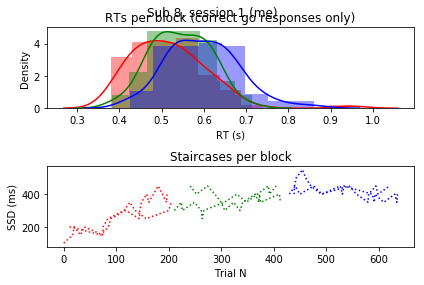

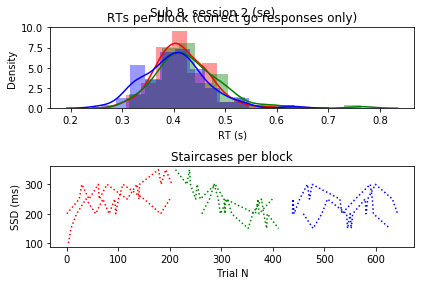

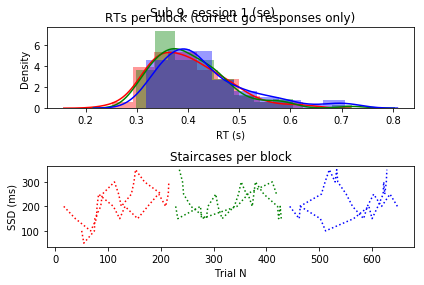

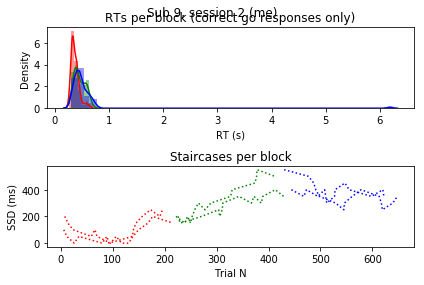

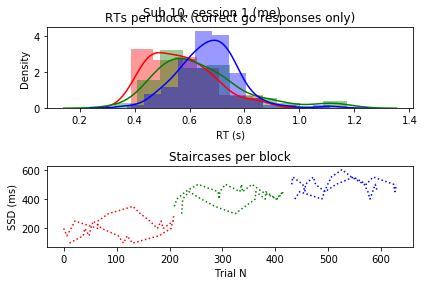

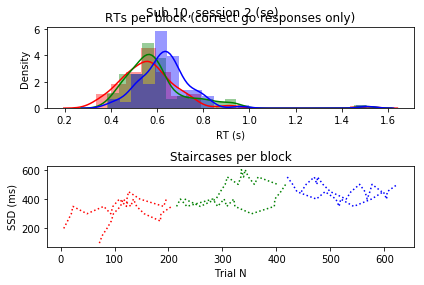

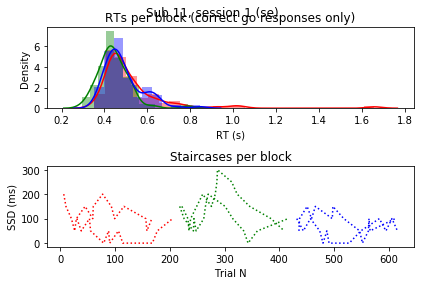

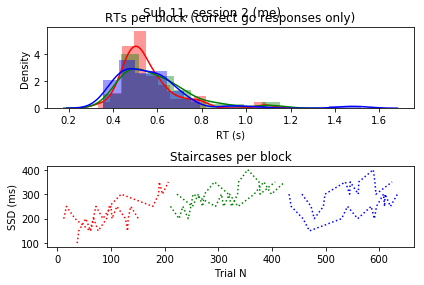

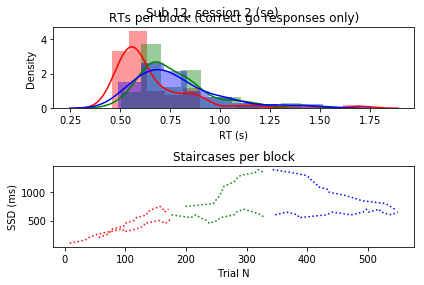

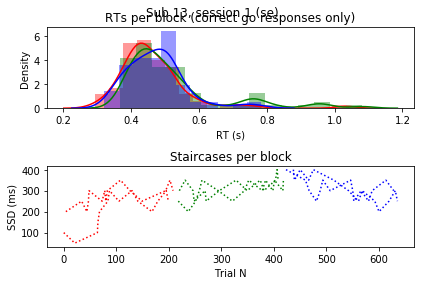

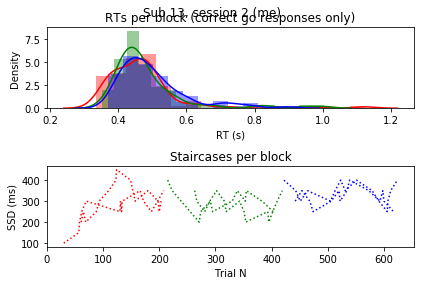

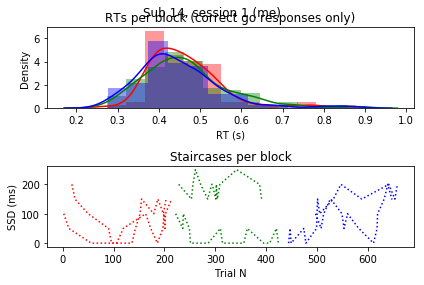

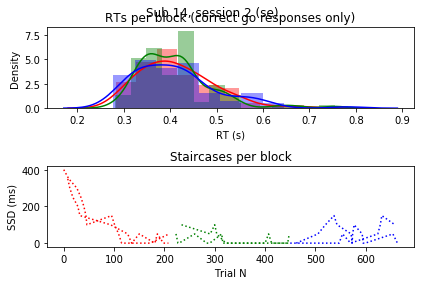

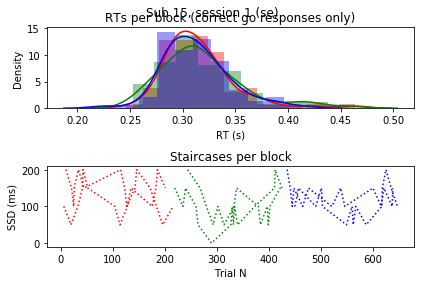

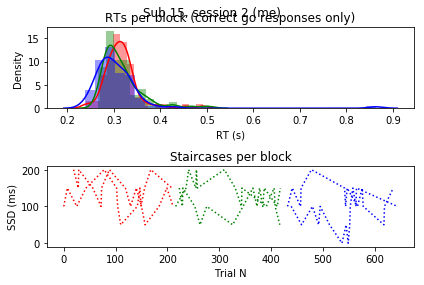

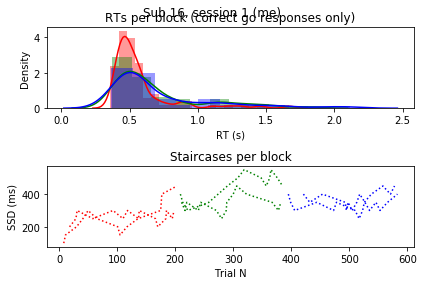

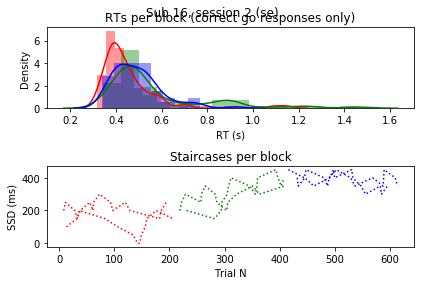

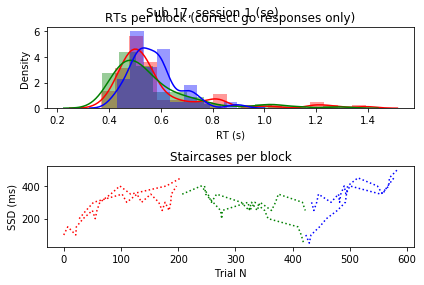

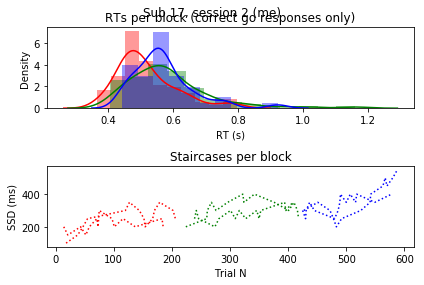

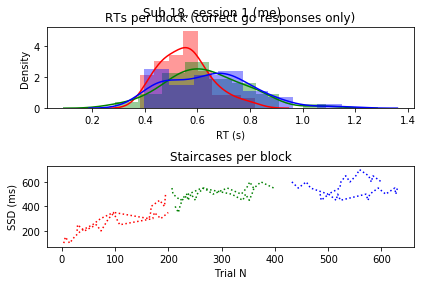

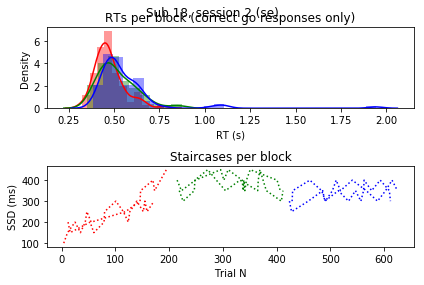

In [7]:
behav_data_dict = {'./data/raw/behavior/S1s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S1s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S2s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S2s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S3s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S3s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S4s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S4s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S5s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S5s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S6s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S6s2-stop_fmri.log': 'se',  ### TO DO: combine log files properly for this pp
                   './data/raw/behavior/S7s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S7s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S8s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S8s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S9s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S9s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S10s1-stop_fmri.log': 'me',
                   './data/raw/behavior/to_combine/S10s2-stop_combined.log': 'se',
#                   './data/raw/behavior/S10s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S11s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S11s2-stop_fmri.log': 'me',
#                    './data/raw/behavior/S12s1-stop_fmri2.log': 'me',  # maybe just remove this one? Useless data anyway
                   './data/raw/behavior/S12s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S13s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S13s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S14s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S14s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S15s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S15s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S16s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S16s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S17s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S17s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S18s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S18s2-stop_fmri.log': 'se'
                  }
print(len(behav_data_dict))
out_dir = './data/deriv/fmriprep/'

for fn, ses in behav_data_dict.items():
    print(fn)
    get_behavioral_descriptives(fn = fn, plot_save_fn=fn.replace('.log', '_behav.png'), 
                                save=True, out_dir=out_dir, log=None, return_long=False, return_wide=True,
                                session_type=ses)

### Behavioral analyses
Make sure theres no difference in SSRT "performance" between sessions

In [203]:
## Get SSRTs
all_behav = []

for fn, ses in behav_data_dict.items():
#    print(fn)
    this_ses = parse_log_file(fn = fn,
                                    save=False, log=None, return_long=False, return_wide=True,
                                    session_type=ses)
    this_ses['session_type'] = ses
    all_behav.append(this_ses)
dat = pd.concat(all_behav)

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [209]:
import re
regex = re.compile('.*S(?P<sub>\d+)s(?P<ses>\d+)*')
dat['session_n'] = dat['Subject'].apply(lambda x: regex.match(x)['ses'])
dat['subject'] = dat['Subject'].apply(lambda x: regex.match(x)['sub'])

# remove RTs > 2s
dat = dat.loc[(dat['rt'] < 2) | (pd.isnull(dat['rt']))]

In [210]:
def get_go_rt(x):
    go_rts = x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'].mean()
    return go_rts

def get_median_go_rt(x):
    go_rts = np.median(x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'])
    return go_rts

def get_failed_stop_rts(x):
    failed_stop_rts = x.loc[x.event_type=='failed_stop', 'rt'].mean()
    return failed_stop_rts

def get_ssrt(x):
    ### Mean method (deH et al)
    failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')

    # mean SSD
    mean_ssd = np.nanmean(x.ssd)/1e3 #to ms
    
    # go RT at failed_stop_rate percentile
    go_rt_at_percentile = np.percentile(x.loc[(x.trial_type=='go') & pd.notnull(x.rt) & (x.correct_response==True), 'rt'], failed_stop_rate*100)
    ssrt = go_rt_at_percentile - mean_ssd
    return ssrt

def get_accuracy(x):
    return x.loc[x.event_type=='go_trial', 'correct_response'].mean()

def get_ssd(x):
    return x.ssd.mean(skipna=True)

def get_perc_inhib(x):
    failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')
    return failed_stop_rate

In [211]:
aggregated = pd.concat([dat.groupby(['subject', 'session_type']).apply(get_ssrt),
                        dat.groupby(['subject', 'session_type']).apply(get_go_rt),
                        dat.groupby(['subject', 'session_type']).apply(get_failed_stop_rts),
                        dat.groupby(['subject', 'session_type']).apply(get_accuracy),
                        dat.groupby(['subject', 'session_type']).apply(get_ssd),
                        dat.groupby(['subject', 'session_type']).apply(get_perc_inhib),
                        dat.groupby(['subject', 'session_type']).apply(get_median_go_rt)], 
                 axis=1).rename(columns={0: 'SSRT',
                                         1: 'Go mRT',
                                         2: 'Failed stop mRT',
                                         3: 'Go accuracy',
                                         4: 'SSD',
                                         5: 'Percentage inhibition',
                                         6: 'Median go RT'}).reset_index()
# drop 12 for stats
aggregated = aggregated.loc[aggregated['subject'] != '12']


t(16) = 0.312, p = 0.759, p(corrected) = 1.000  (SSRT)
t(16) = -2.347, p = 0.032, p(corrected) = 0.161  (Go mRT)
t(16) = -2.880, p = 0.011, p(corrected) = 0.065  (Failed stop mRT)
t(16) = 0.479, p = 0.639, p(corrected) = 1.000  (Go accuracy)
t(16) = -1.564, p = 0.137, p(corrected) = 0.549  (SSD)
t(16) = 1.069, p = 0.301, p(corrected) = 0.903  (Percentage inhibition)
(-0.021186460188360238, 0.9356736481785825)
(-0.08819873491006312, 0.736410759106876)


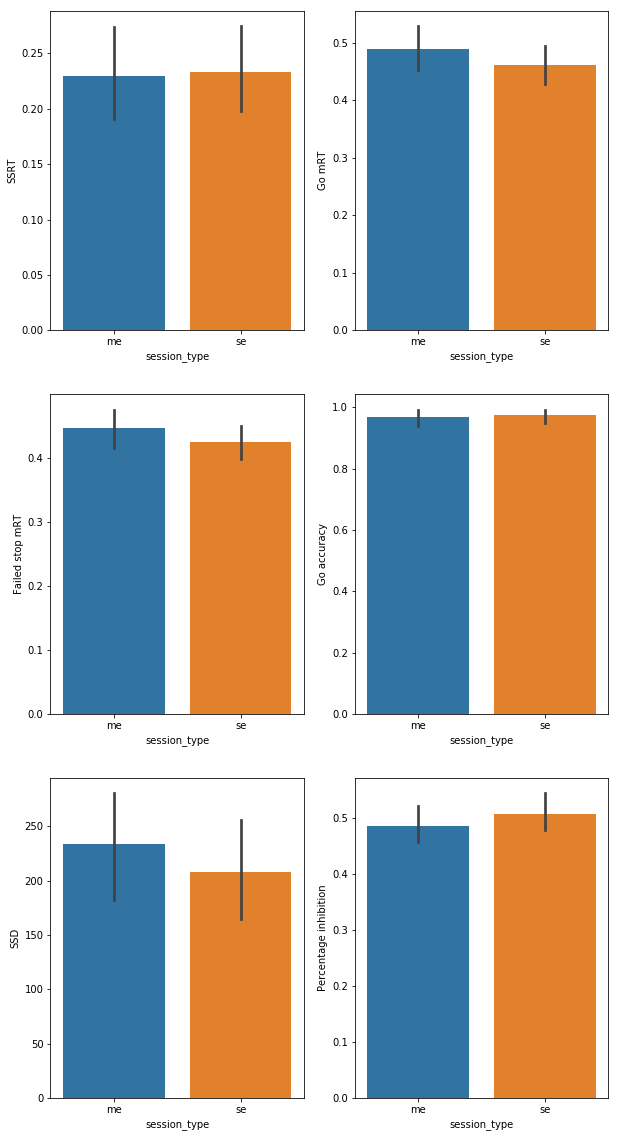

In [212]:
import seaborn as sns
from scipy import stats
import statsmodels as sm
from statsmodels.sandbox.stats import multicomp
f, ax = plt.subplots(3,2)

test_names = ['SSRT', 'Go mRT', 'Failed stop mRT', 'Go accuracy', 'SSD', 'Percentage inhibition']
all_tests = []
for i, colname in enumerate(test_names):
    sns.barplot(x='session_type', y=colname, data=aggregated, ax=ax[int(np.floor(i/2)), int(i%2)])
    all_tests.append(stats.ttest_rel(aggregated.loc[aggregated.session_type=='se', colname], 
                                     aggregated.loc[aggregated.session_type=='me', colname], nan_policy='omit'))
f.set_size_inches(10, 20)

# multiple comparison corrections
p_vals = multicomp.multipletests([x[1] for x in all_tests], method='h')[1]
[print('t(16) = %.3f, p = %.3f, p(corrected) = %.3f  (%s)' %(x[0], x[1], y, name)) for name, x,y in zip(test_names, all_tests, p_vals)]

# correlation between median go RTs and SSRTs?
print(stats.pearsonr(aggregated.loc[aggregated.session_type=='se', 'Median go RT'],
                     aggregated.loc[aggregated.session_type=='se', 'SSRT']))

print(stats.pearsonr(aggregated.loc[aggregated.session_type=='me', 'Median go RT'],
                     aggregated.loc[aggregated.session_type=='me', 'SSRT']))

# far from it

Overall, the RTs *look* a little bit lower in the single echo condition. The results are not significant after MC correction, but it may still be worthwhile to think about the meaning of a potential RT difference.

The only obvious difference between SE/ME I can think of were the sound levels of the sequence. The ME was very loud. In combination with the auditory nature, one might wonder whether this interferes with performance.
However, if the *sound levels* were the issue, it is not clear why the *go RTs* would be any slower. In go trials, there is no sound.

One option may be that participant applied a waiting-strategy, to 'see if the tone comes'. However, participants were explicitly not instructed to do this. In terms of data, if participants would apply this strategy (more in ME than in SE), the successfull inhibition rate should be higher in the ME condition (it isn't), and as a result, the SSDs would be much higher (they are a little bit higher but not significantly - even without MC correction and a high alpha). Also, in this case, the SSRT should correlate with the median Go RT - which it doesn't (not even close).

Alternatively, participants just missed the auditory tone in some trials in the ME session. This would cause responding during stop trials, and as a result decrease SSDs. However, SSDs are not significantly lower in the ME session (even without MC corrections), lending little credit to this interpretation..

Most importantly (I would say), the SSRTs between conditions show no signs of any difference.

With a very liberal look at the data, one might say that the participants performed a little bit "better" in the SE session: RTs were lower, percentage inhibition was higher (but not significantly), go accuracy was higher (but not significantly). But even accepting this interpretation, the effect size is minimal, and behavior is *almost* the same. Yet, the neural difference is quite clear.

Maybe there was a time effect? Were people better at the second session?

In [1]:
aggregated = dat.groupby(['subject', 'session_n']).apply(get_ssrt).reset_index()#.rename(columns={0: 'SSRT'}, inplace=True)
aggregated = aggregated.rename(columns={0: 'SSRT'})
aggregated = aggregated.loc[aggregated.subject != '12']

sns.barplot(x='session_n', y='SSRT', data=aggregated)
stats.ttest_rel(aggregated.loc[aggregated.session_n=='1', 'SSRT'], aggregated.loc[aggregated.session_n=='2', 'SSRT'])

NameError: name 'dat' is not defined

#### Close but no cigar